In [1]:
using Random, Distributions
using LinearAlgebra, Statistics
using Plots

In [2]:
# Parameters to choose

γ = 0.05:0.05:0.2
β = 0.8 # 4% interest rate

ρ = 0.866
σ = 0.059
σ_0 = sqrt(σ^2/(1 - ρ^2)) # 0.12
m = 0.088

m_0 = 0.9
f = 20
c_e = 15

15

In [3]:
# Discretize AR(1) - Tauchen Method

function tauchen(m, σ, ρ=0.866, n_std = 7, N = 120)
    # Discretize space
    m_s = m/(1-ρ)
    σ_s = σ/sqrt(1-ρ^2)
    s_min = m_s - n_std * σ_s/2
    s_max = m_s + n_std * σ_s
    log_s = range(s_min, s_max, length = N)
    s = exp.(log_s)
    d = log_s[2] - log_s[1]
    d_half = d/2
    
    # Tranformation matrix
    P = zeros(N,N)
    for i in eachindex(log_s) 
        P[i,1] = cdf(Normal(0,1), (s_min + d_half -ρ*log_s[i]-m)/σ)
        P[i,N] = 1 - cdf(Normal(0,1), (s_max - d_half -ρ*log_s[i]-m)/σ)
        for j in 2:N-1
            P[i,j] = cdf(Normal(0,1), (log_s[j] + d_half -ρ*log_s[i]-m)/σ) - cdf(Normal(0,1), (log_s[j]  - d_half -ρ*log_s[i]-m)/σ)
        end    
    end
    return P,s
end

tauchen (generic function with 4 methods)

In [4]:
(P,s) = tauchen(m, σ);

In [5]:
# Find Value Function

function findV_g(p, V0, P, s, γ, f=20, β=0.8, max_it = 1e4, tol=1e-8)
    i = 1 
    dist = 1e3
    V = V0
    N = length(s)
    
    # optimal q
    q = (p*s).^(1/γ)
    # profit function
    profit = p*q - (q.^(1+γ))./((1+γ)*s)-f*ones(N)
    
    while (i < max_it) & (dist > tol)
        V1 =  max.(0, profit + β * P'*V)
        dist = norm(V1 - V)
        V = V1
        i += 1
    end
    
    return V
    
end

findV_g (generic function with 5 methods)

In [6]:
function fr_entry_g(p, P, s, g, γ, c_e=15)
    V0 = zeros(N)
    V = findV_g(p, V0, P, s,  γ)
    return  β*g'*V - c_e
end

fr_entry_g (generic function with 2 methods)

In [7]:
function eqm_price_g(P, s, g,  γ, max_it = 1e3, tol=1e-8)
    p_max = 100
    p_min = 0
    v_e = 1e3
    i = 0
    
    while (i < max_it) & (p_max - p_min > tol)
        p = (p_max + p_min)/2
        v_e = fr_entry_g(p, P, s, g, γ)
        if v_e > 0
            p_max = p
        else
            p_min = p
        end
        i +=1
    end
    
    return p_min
end

eqm_price_g (generic function with 3 methods)

In [8]:
# Exit threshold

function exit_s_g(p, s, P, γ, f=20)
    v = -1
    # optimal q
    q = (p*s).^(1/γ)
    # profit function
    profit = p*q - (q.^(1+γ))./((1+γ)*s)-f*ones(N)
    
    V0 = zeros(N)
    V = profit + β*P'*findV_g(p, V0, P, s, γ)
    
    return sum(V.<0)
end

exit_s_g (generic function with 2 methods)

In [9]:
# moments 

N = length(s)
    
    # Initial distribution
    G = cdf(LogNormal(m_0,σ_0),s)
    g = zeros(N)
    g[1] = G[1]

    for i in 2:N
        g[i] = G[i] - G[i-1]
    end
    g=round.(g/sum(g),digits=4);
    


In [10]:
price = zeros(4)
k_s = zeros(4)
μ = zeros(4,N)
bar_μ = zeros(4,N)
α = zeros(4,5)
q =zeros(4,N)
    

for l in 1:4
    
    price[l] = eqm_price_g(P, s, g, γ[l])   
    
    q[l,:] = (price[l]*s).^(1/γ[l])
    # Exit rule
    k_s[l] = exit_s_g(price[l],s, P, γ[l])
    x = convert(Int64,k_s[l])
    
    P_tilde = zeros(N,N)
    
    for i in x+1:N
        P_tilde[i,:] = P[i,:]
    end
    
    # Invariant distribution
    μ[l,:]=inv(I-P_tilde')*g
    bar_μ[l,:] =  μ[l,:]/sum(μ[l,:])

    MU = zeros(5,N)
    for i in eachindex(α[l,:])
        MU[i,:] = (P_tilde')^(i) * g
        α[l,i] = sum(MU[i,:])/sum(g)
    end
end

In [11]:
# Survival rates
round.(α,digits=3)

4×5 Array{Float64,2}:
 0.466  0.319  0.215  0.143  0.093
 0.501  0.352  0.243  0.165  0.11
 0.536  0.386  0.272  0.189  0.129
 0.571  0.42   0.304  0.215  0.149

In [12]:
# exit threshold
k_s'

1×4 Adjoint{Float64,Array{Float64,1}}:
 65.0  64.0  63.0  62.0

In [13]:
# Turnover rate in model: Entry/All firms i.e. λ/μ(S)

print("0:", 1/sum(α[1,:])," 10:", 1/sum(α[2,:])," 20:", 1/sum(α[3,:])," 30:", 1/sum(α[4,:]))

0:0.8091131357164845 10:0.7297684321497812 20:0.6614931834538974 30:0.6025740546961846

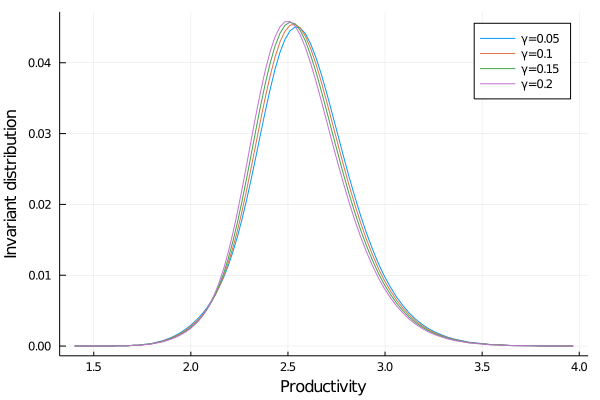

In [14]:
# Invariant distribution of productivity

plot5 = plot(s[10:110],bar_μ[1,10:110],label = "γ=0.05" ) 
plot!(s[10:110],bar_μ[2,10:110],label = "γ=0.1" )
plot!(s[10:110],bar_μ[3,10:110],label = "γ=0.15" ) 
plot!(s[10:110],bar_μ[4,10:110],label = "γ=0.2" )
xlabel!("Productivity")
ylabel!("Invariant distribution")
#savefig(plot5,"plot5.png")

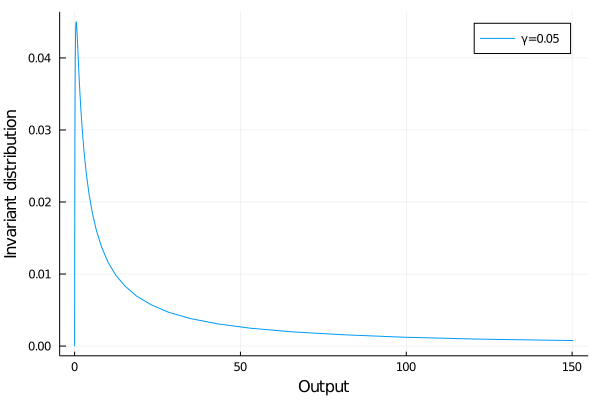

In [15]:
# Invariant distribution of firm size (in terms of output)

plot61 =plot(q[1,1:95],bar_μ[1,1:95],label = "γ=0.05" )  
xlabel!("Output")
ylabel!("Invariant distribution")
#savefig(plot61,"plot6_1.png")


#plot!(q[2,1:47],bar_μ[2,1:47],label = "γ=0.4" ) 
#plot!(q[3,1:47],bar_μ[3,1:47],label = "γ=0.6" )
#plot!(q[4,1:47],bar_μ[4,1:47],label = "γ=0.8" ) 


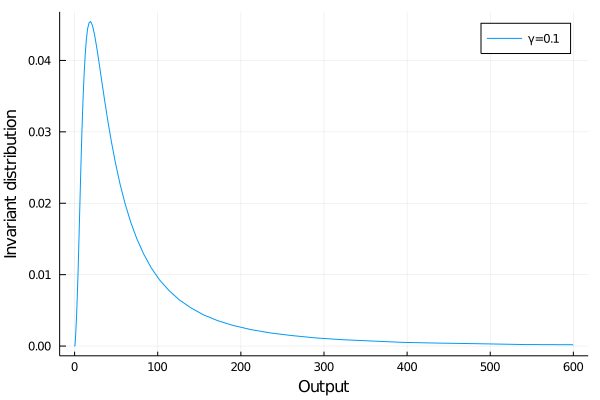

In [16]:
plot62 =plot(q[2,1:100],bar_μ[2,1:100],label = "γ=0.1" )  
xlabel!("Output")
ylabel!("Invariant distribution")
#savefig(plot62,"plot6_2.png")

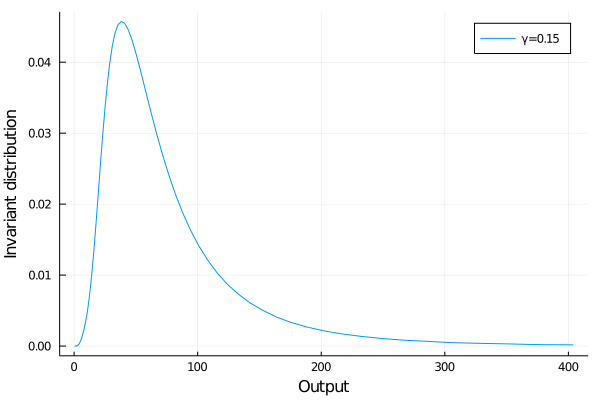

In [17]:
plot63 =plot(q[3,1:100],bar_μ[3,1:100],label = "γ=0.15" )  
xlabel!("Output")
ylabel!("Invariant distribution")
#savefig(plot63,"plot6_3.png")

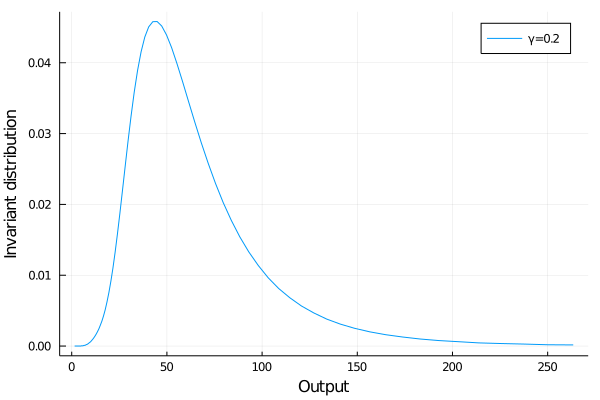

In [18]:
plot64 =plot(q[4,1:100],bar_μ[4,1:100],label = "γ=0.2" )  
xlabel!("Output")
ylabel!("Invariant distribution")
#savefig(plot64,"plot6_4.png")